# XDMoD Python API Usage Example
University at Buffalo — Center for Computational Research

## Introduction
The `xdmod` Python module provides API access to the data in XDMoD. This notebook provides an introductory example showing how to use the module. You will use the XDMoD API to query data, load it into a [Pandas](https://pandas.pydata.org/) [DataFrame](https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.html), and generate plots. The example dataset contains the number of active users of [ACCESS](https://access-ci.org/) resources per day of the week over a 4-month period.

## Import the XDMoD Data Warehouse module

In [1]:
from xdmod.datawarehouse import DataWarehouse

## Configure IPython notebook formatting of plots and tables

In [1]:
from IPython.display import display, Markdown
import matplotlib.pyplot as plt

plt.rcParams['figure.figsize'] = [12, 8]

def display_df_md_table(df):
    return display(Markdown(df.replace('\n', '<br/>', regex=True).to_markdown()))

## Initialize the data warehouse
To access the data in XDMoD, you first need to construct a `DataWarehouse` object and provide the URL of the XDMoD instance as well as an API token or equivalent authentication information. In this prototype, the API token is set to `None`, which causes the Python code to pull the authentication data from shell environment variables.

In [1]:
dw = DataWarehouse(xdmod_host='https://xdmod-dev.ccr.xdmod.org', api_token=None)

## Get the data
Use the `get_data()` method to query XDMoD and load the resulting data into a Pandas DataFrame. In this example, get the number of active users of ACCESS resources over a 4-month period. Each of the parameters of the method will be explained later in this notebook. Use `with` to create a runtime context; this is also explained later in this notebook.

In [1]:
with dw:
    data = dw.get_data(
        duration=('2021-01-17', '2021-05-17'),
        realm='Jobs',
        metric='Number of Users: Active',
    )

## Plot the data

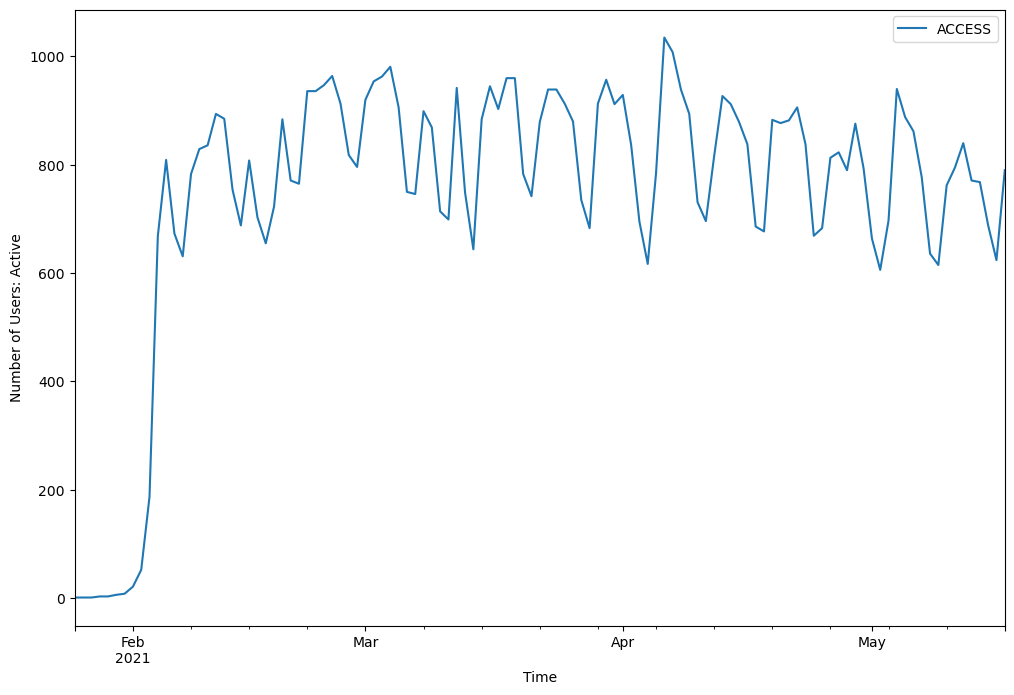

In [1]:
ax = data.plot()
ax.set_ylabel('Number of Users: Active')
ax.legend(title='')

## Do further data processing
You can do further processing on the DataFrame to produce analysis and plots beyond those that are available in the XDMoD portal.

For example, add a column for the day of the week:

In [1]:
data['Day Name'] = data.index.strftime('%w\n%a')

Then, show a box plot of the data grouped by day of the week:

Text(0.5, 0.98, '')

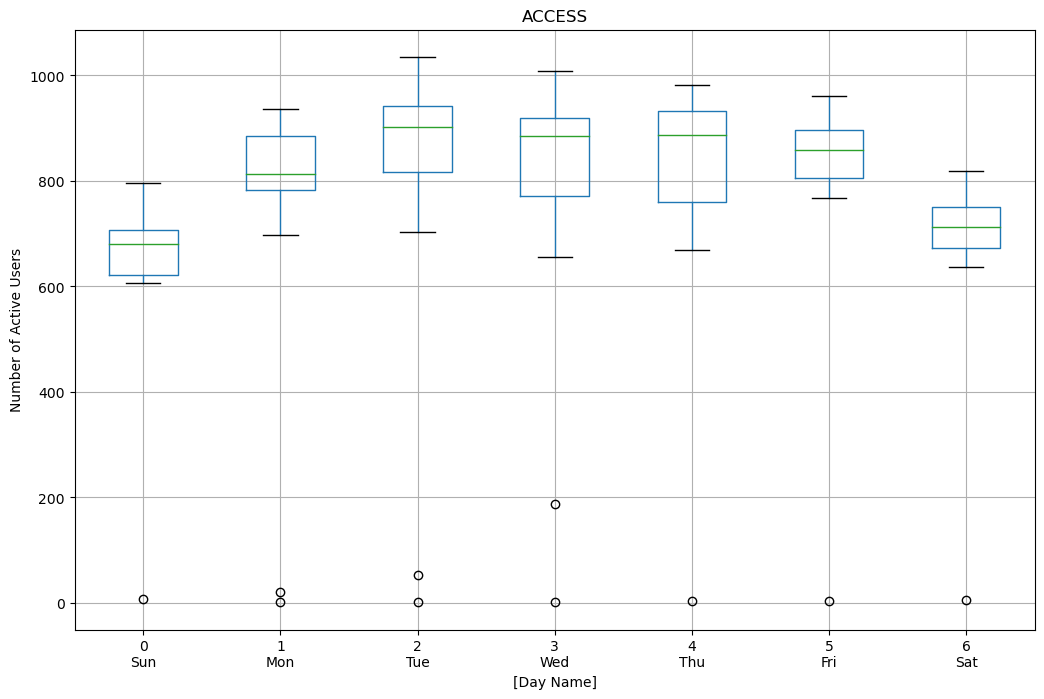

In [1]:
ax = data.boxplot(by='Day Name')
ax.set_ylabel('Number of Active Users')
plt.suptitle('')

## Details of the `get_data()` method
Now that you have seen a basic example of using the `get_data()` method, read below for more details on how it works.

### Wrap data warehouse calls in a runtime context
XDMoD data is accessed over a network connection, which involves establishing connections and creating temporary resources. To ensure these connections and resources are cleaned up properly in spite of any runtime errors, you should call data warehouse methods within a **runtime context** by using Python's `with` statement to wrap the execution of XDMoD queries, store the result, and execute any long running calculations outside of the runtime context:

In [1]:
with dw:
    # XDMoD queries would go here
    pass
# Data processing would go here
pass

### Default parameters
The `get_data()` method has a number of parameters; their default values are shown below, and the parameters are explained in more detail further below.

In [1]:
with dw:
    data = dw.get_data(
        duration='Previous month',
        realm='Jobs',
        metric='CPU Hours: Total',
        dimension='None',
        filters={},
        timeseries=True,
        aggregation_unit='Auto',
    )

### Duration
The **duration** provides the time constraints of the data to be fetched from the XDMoD data warehouse. You can get a list of valid durations by calling the `get_durations()` method.

In [1]:
with dw:
    print(dw.get_durations())

('Yesterday', '7 day', '30 day', '90 day', 'Month to date', 'Previous month', 'Quarter to date', 'Previous quarter', 'Year to date', 'Previous year', '1 year', '2 year', '3 year', '5 year', '10 year', '2023', '2022', '2021', '2020', '2019', '2018', '2017')


The duration can instead be specified as start and end times:

In [1]:
with dw:
    data = dw.get_data(duration=('2022-12-03', '2022-12-23'))

### Realm
A **realm** is a category of data in the XDMoD data warehouse. You can use the `get_realms()` method to get a DataFrame containing the list of available realms.

In [1]:
with dw:
    realms = dw.get_realms()
    display_df_md_table(realms)

| id                  | label                |
|:--------------------|:---------------------|
| Accounts            | Accounts             |
| Allocations         | Allocations          |
| Cloud               | Cloud                |
| Gateways            | Gateways             |
| Jobs                | Jobs                 |
| Requests            | Requests             |
| ResourceAllocations | Resource Allocations |
| SUPREMM             | SUPREMM              |

### Metric
A **metric** is statistic for which data exists in a given realm. You can use the `get_metrics(realm)` method to get a DataFrame containing the list of valid metrics in the given realm. The realm must be passed in as a string.

In [1]:
with dw:
    metrics = dw.get_metrics('Jobs')
    display_df_md_table(metrics)

| id                                 | label                                        | description                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |
|:-----------------------------------|:---------------------------------------------|:---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------|
| utilization                        | ACCESS Utilization (%)                       | The percentage of the ACCESS obligation of a resource that has been utilized by ACCESS jobs.<br/><i> ACCESS Utilization:</i> The ratio of the total CPU hours consumed by ACCESS jobs over a given time period divided by the total CPU hours that the system is contractually required to provide to ACCESS during that period. It does not include non-ACCESS jobs.<br/>It is worth noting that this value is a rough estimate in certain cases where the resource providers don't provide accurate records of their system specifications, over time.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   |
| rate_of_usage                      | Allocation Usage Rate (XD SU/Hour)           | The rate of ACCESS allocation usage in XD SUs per hour.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    |
| avg_cpu_hours                      | CPU Hours: Per Job                           | The average CPU hours (number of CPU cores x wall time hours) per ACCESS job.<br/>For each job, the CPU usage is aggregated. For example, if a job used 1000 CPUs for one minute, it would be aggregated as 1000 CPU minutes or 16.67 CPU hours.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           |
| total_cpu_hours                    | CPU Hours: Total                             | The total CPU hours (number of CPU cores x wall time hours) used by ACCESS jobs.<br/>For each job, the CPU usage is aggregated. For example, if a job used 1000 CPUs for one minute, it would be aggregated as 1000 CPU minutes or 16.67 CPU hours.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        |
| max_processors                     | Job Size: Max (Core Count)                   | The maximum size ACCESS job in number of cores.<br/><i>Job Size: </i>The total number of processor cores used by a (parallel) job.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         |
| min_processors                     | Job Size: Min (Core Count)                   | The minimum size ACCESS job in number of cores.<br/><i>Job Size: </i>The total number of processor cores used by a (parallel) job.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         |
| normalized_avg_processors          | Job Size: Normalized (% of Total Cores)      | The percentage average size ACCESS job over total machine cores.<br><i>Normalized Job Size: </i>The percentage total number of processor cores used by a (parallel) job over the total number of cores on the machine.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     |
| avg_processors                     | Job Size: Per Job (Core Count)               | The average job size per ACCESS job.<br><i>Job Size: </i>The number of processor cores used by a (parallel) job.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                           |
| avg_job_size_weighted_by_cpu_hours | Job Size: Weighted By CPU Hours (Core Count) | The average ACCESS job size weighted by CPU Hours. Defined as <br><i>Average Job Size Weighted By CPU Hours: </i> sum(i = 0 to n){ job i core count * job i cpu hours}/sum(i =  0 to n){job i cpu hours}                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   |
| avg_job_size_weighted_by_xd_su     | Job Size: Weighted By XD SUs (Core Count)    | The average ACCESS job size weighted by charge in XD SUs. Defined as <br><i>Average Job Size Weighted By XD SUs: </i> sum(i = 0 to n){job i core count*job i charge in xd sus}/sum(i =  0 to n){job i charge in xd sus}                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                    |
| avg_nu                             | NUs Charged: Per Job                         | The average amount of NUs charged per ACCESS job.<br/><br/><i>NU - Normalized Units: </i>Roaming allocations are awarded in XSEDE Service Units (SUs). 1 XSEDE SU is defined as one CPU-hour on a Phase-1 DTF cluster. <br/>For usage on a resource that is charged to a Roaming allocation, a normalization factor is applied. The normalization factor is based on<br/>the method historically used to calculate 'Normalized Units' (Cray X-MP-equivalent SUs), which derives from a resource's performance on the HPL<br/>benchmark.<br/><br/><br/>Specifically, 1 Phase-1 DTF SU = 21.576 NUs, and the XD SU conversion factor for a resource is calculated by taking its NU conversion factor<br/>and dividing it by 21.576. The standard formula for calculating a resource's NU conversion factor is: (Rmax * 1000 / 191) / P<br/>where Rmax is the resource's Rmax result on the HPL benchmark in Gflops and P is the number of processors used in the benchmark.<br/>In the absence of an HPL benchmark run, a conversion factor can be agreed upon, based on that of an architecturally similar platform<br/>and scaled according to processor performance differences.<br/><br/><br/>Conversion to Roaming SUs is handled by the XSEDE central accounting system, and RPs are only required to report usage in local SUs for all allocations.<br/><br/><br/>Defining an SU charge for specialized compute resources (such as visualization hardware) or non-compute resources (such as storage) is possible, but there is no XSEDE-wide policy for doing so.    |
| total_nu                           | NUs Charged: Total                           | The total amount of NUs charged by ACCESS jobs.<br/><br/><i>NU - Normalized Units: </i>Roaming allocations are awarded in XSEDE Service Units (SUs). 1 XSEDE SU is defined as one CPU-hour on a Phase-1 DTF cluster.<br/>For usage on a resource that is charged to a Roaming allocation, a normalization factor is applied. The normalization factor is based on <br/>the method historically used to calculate 'Normalized Units' (Cray X-MP-equivalent SUs), which derives from a resource's performance on the HPL <br/>benchmark.<br/><br/><br/>Specifically, 1 Phase-1 DTF SU = 21.576 NUs, and the XD SU conversion factor for a resource is calculated by taking its NU conversion factor <br/>and dividing it by 21.576. The standard formula for calculating a resource's NU conversion factor is: (Rmax * 1000 / 191) / P <br/>where Rmax is the resource's Rmax result on the HPL benchmark in Gflops and P is the number of processors used in the benchmark. <br/>In the absence of an HPL benchmark run, a conversion factor can be agreed upon, based on that of an architecturally similar platform <br/>and scaled according to processor performance differences.<br/><br/><br/>Conversion to Roaming SUs is handled by the XSEDE central accounting system, and RPs are only required to report usage in local SUs for all allocations.<br/><br/><br/>Defining an SU charge for specialized compute resources (such as visualization hardware) or non-compute resources (such as storage) is possible, but there is no XSEDE-wide policy for doing so. |
| avg_node_hours                     | Node Hours: Per Job                          | The average node hours (number of nodes x wall time hours) per ACCESS job.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                 |
| total_node_hours                   | Node Hours: Total                            | The total node hours (number of nodes x wall time hours) used by ACCESS jobs.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              |
| active_allocation_count            | Number of Allocations: Active                | The total number of funded projects that used ACCESS resources.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                            |
| active_institution_count           | Number of Institutions: Active               | The total number of institutions that used ACCESS resources.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               |
| job_count                          | Number of Jobs Ended                         | The total number of ACCESS jobs that ended within the selected duration.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   |
| running_job_count                  | Number of Jobs Running                       | The total number of ACCESS jobs that are running.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                          |
| started_job_count                  | Number of Jobs Started                       | The total number of ACCESS jobs that started executing within the selected duration.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                       |
| submitted_job_count                | Number of Jobs Submitted                     | The total number of ACCESS jobs that submitted/queued within the selected duration.<i>                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                     |
| gateway_job_count                  | Number of Jobs via Gateway                   | The total number of ACCESS  jobs submitted through gateways (e.g., via a community user account) that ended within the selected duration.<br/><i>Job: </i>A scheduled process for a computer resource in a batch processing environment.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   |
| active_pi_count                    | Number of PIs: Active                        | The total number of PIs that used ACCESS resources.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                        |
| active_resource_count              | Number of Resources: Active                  | The total number of active ACCESS resources.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               |
| active_person_count                | Number of Users: Active                      | The total number of users that used ACCESS resources.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      |
| expansion_factor                   | User Expansion Factor                        | Gauging ACCESS job-turnaround time, it measures the ratio of wait time and the total time from submission to end of execution.<br/><i>User Expansion Factor = ((wait duration + wall duration) / wall duration). </i>                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                      |
| avg_waitduration_hours             | Wait Hours: Per Job                          | The average time, in hours, a ACCESS job waits before execution on the designated resource.<br/><i>Wait Time: </i>Wait time is defined as the linear time between submission of a job by a user until it begins to execute.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |
| total_waitduration_hours           | Wait Hours: Total                            | The total time, in hours, ACCESS jobs waited before execution on their designated resource.<br/><i>Wait Time: </i>Wait time is defined as the linear time between submission of a job by a user until it begins to execute.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                |
| avg_wallduration_hours             | Wall Hours: Per Job                          | The average time, in hours, a job takes to execute.<br/>In timeseries view mode, the statistic shows the average wall time per job per time period. In aggregate view mode the statistic only includes the job wall hours between the defined time range. The wall hours outside the time range are not included in the calculation.<br /> <i>Wall Time:</i> Wall time is defined as the linear time between start and end time of execution for a particular job.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         |
| total_wallduration_hours           | Wall Hours: Total                            | The total time, in hours, ACCESS jobs took to execute.<br/><i>Wall Time:</i> Wall time is defined as the linear time between start and end time of execution for a particular job.                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                         |
| avg_su                             | XD SUs Charged: Per Job                      | The average amount of XD SUs charged per ACCESS job.<br/><br/><i>XD SU: </i>1 XSEDE SU is defined as one CPU-hour on a Phase-1 DTF cluster.<br/><br/><i>SU - Service Units: </i>Computational resources on the XSEDE are allocated and charged in service units (SUs). SUs are defined locally on each system, with conversion factors among systems based on HPL benchmark results.<br/><br/><br/>Current TeraGrid supercomputers have complex multi-core and memory hierarchies. Each resource has a specific configuration that determines the number (N) of cores that can be dedicated to a job without slowing the code (and other user and system codes). Each resource defines for its system the minimum number of SUs charged for a job running in the default batch queue, calculated as wallclock runtime multiplied by N. Minimum charges may apply.<br/><br/><br/>Note: The actual charge will depend on the specific requirements of the job (e.g., the mapping of the cores across the machine, or the priority you wish to obtain).<br/><br/><br/>Note 2: The SUs show here have been normalized against the XSEDE Roaming service. Therefore they are comparable across resources.                                                                                                                                                                                                                                                                                                                                                                       |
| total_su                           | XD SUs Charged: Total                        | The total amount of XD SUs charged by ACCESS jobs.<br/><br/><i>XD SU: </i>1 XSEDE SU is defined as one CPU-hour on a Phase-1 DTF cluster.<br/><br/><i>SU - Service Units: </i>Computational resources on the XSEDE are allocated and charged in service units (SUs). SUs are defined locally on each system, with conversion factors among systems based on HPL benchmark results.<br/><br/><br/>Current TeraGrid supercomputers have complex multi-core and memory hierarchies. Each resource has a specific configuration that determines the number (N) of cores that can be dedicated to a job without slowing the code (and other user and system codes). Each resource defines for its system the minimum number of SUs charged for a job running in the default batch queue, calculated as wallclock runtime multiplied by N. Minimum charges may apply.<br/><br/><br/>Note: The actual charge will depend on the specific requirements of the job (e.g., the mapping of the cores across the machine, or the priority you wish to obtain).<br/><br/><br/>Note 2: The SUs show here have been normalized against the XSEDE Roaming service. Therefore they are comparable across resources.                                                                                                                                                                                                                                                                                                                                                                         |

### Dimension
A **dimension** is a grouping of data. You can use the `get_dimensions(realm)` method to get a DataFrame containing the list of valid dimensions in the given realm. The realm must be passed in as a string.

In [1]:
with dw:
    dimensions = dw.get_dimensions('Jobs')
    display_df_md_table(dimensions)

| id             | label            | description                                                                                                      |
|:---------------|:-----------------|:-----------------------------------------------------------------------------------------------------------------|
| none           | None             | Summarizes jobs reported to the ACCESS allocations service (excludes non-ACCESS usage of the resource).          |
| allocation     | Allocation       | A funded project that is allowed to run jobs on resources.                                                       |
| fieldofscience | Field of Science | The field of science indicated on the allocation request pertaining to the running jobs.                         |
| gateway        | Gateway          | A science gateway is a portal set up to aid submiting jobs to resources.                                         |
| grant_type     | Grant Type       | A categorization of the projects/allocations.                                                                    |
| jobsize        | Job Size         | A categorization of jobs into discrete groups based on the number of cores used by each job.                     |
| jobwaittime    | Job Wait Time    | A categorization of jobs into discrete groups based on the total linear time each job waited.                    |
| jobwalltime    | Job Wall Time    | A categorization of jobs into discrete groups based on the total linear time each job took to execute.           |
| nsfdirectorate | NSF Directorate  | The NSF directorate of the field of science indiciated on the allocation request pertaining to the running jobs. |
| nodecount      | Node Count       | A categorization of jobs into discrete groups based on node count.                                               |
| pi             | PI               | The principal investigator of a project.                                                                         |
| pi_institution | PI Institution   | Organizations that have PIs with allocations.                                                                    |
| parentscience  | Parent Science   | The parent of the field of science indiciated on the allocation request pertaining to the running jobs.          |
| queue          | Queue            | Queue pertains to the low level job queues on each resource.                                                     |
| resource       | Resource         | A resource is a remote computer that can run jobs.                                                               |
| resource_type  | Resource Type    | A categorization of resources into by their general capabilities.                                                |
| provider       | Service Provider | A service provider is an institution that hosts resources.                                                       |
| username       | System Username  | The specific system username of the users who ran jobs.                                                          |
| person         | User             | A person who is on a PIs allocation, hence able run jobs on resources.                                           |
| institution    | User Institution | Organizations that have users with allocations.                                                                  |
| nsfstatus      | User NSF Status  | Categorization of the users who ran jobs.                                                                        |

### Pass in realms, metrics, and dimensions using labels or IDs

For methods in the API that take realms, metrics, and/or dimensions as arguments, you can pass them in as their labels or their IDs.

In [1]:
with dw:
    data = dw.get_data(
        duration='10 year',
        realm='Resource Allocations', # 'ResourceAllocations' also works
        metric='XD SUs Awarded', # 'awarded_xd_su' also works
        dimension='Service Provider',  # 'provider' also works
    )

### Filters
**Filters** allow you to include only data that have certain values for given dimensions. You can use the `get_filters(realm, dimension)` method to get a DataFrame containing the list of valid filter values for the given dimension in the given realm. The realm and dimension must be passed in as strings.

In [1]:
with dw:
    filters = dw.get_filters('Jobs', 'Service Provider') # 'provider' also works
    display_df_md_table(filters)

|    id | label      |
|------:|:-----------|
|   561 | IU         |
|  1789 | ANL        |
|    68 | Caltech    |
| 10556 | JHU-MARCC  |
|  2734 | CCT-LSU    |
|   844 | NCSA       |
|  2440 | OSG        |
|   848 | PSC        |
|  2101 | LONI-LSU   |
|  1869 | Purdue     |
|   653 | NCAR       |
|   856 | SDSC       |
| 14449 | StonyBrook |
|   476 | TACC       |
|   453 | NICS       |
|   646 | ORNL       |
|   131 | UDEL       |
|    97 | Stanford   |

For methods in the API that take filters as arguments, you must specify the filters as a dictionary in which the keys are dimensions (labels or IDs) and the values are string filter values (labels or IDs) or sequences of string filter values. For example, to return only data for which the field of science is biophysics and the service provider is either NCSA or SDSC:

In [1]:
with dw:
    data = dw.get_data(
        filters={
            'Field of Science': 'Biophysics', # 'fieldofscience': '246' also works
            'Service Provider': ( # 'provider' also works
                'NCSA', # '844' also works
                'SDSC', # '856' also works
            ),
        },
    )

### Timeseries
The timeseries parameter is `True` by default. Set it to `False` to aggregate the data across the entire duration.

In [1]:
with dw:
    data = dw.get_data(timeseries=False)

### Aggregation unit
The **aggregation unit** specifies how data is aggregated. You can get a list of valid aggregation units by calling the `get_aggregation_units()` method.

In [1]:
with dw:
    print(dw.get_aggregation_units())

('Auto', 'Day', 'Month', 'Quarter', 'Year')
